I realized I can't use the test boxes to do fixed cosmology optimization. They'll also be small enough to do in a notebook. So I'll do them here. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pearce.emulator import LemonPepperWet, NashvilleHot
from itertools import product
from GPy.kern import *
import numpy as np
from os import path
from sys import argv
import h5py
from time import time

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
#training_file ='/u/ki/swmclau2/des/Aemulators/xi_hsab_box0/PearceHSABXiBox0.hdf5'
training_file ='/u/ki/swmclau2/des/Aemulators/vdf_hsab_box0/PearceHSABVDFBox0.hdf5'

In [4]:
#test_file = '/u/ki/swmclau2/des/xi_hsab_box0_test/PearceHSABXi.hdf5'
test_file = '/u/ki/swmclau2/des/vdf_hsab_box0_test/PearceHSABVDF.hdf5'

In [5]:
with h5py.File(training_file, 'r') as f:
    HOD_params = len(f.attrs['hod_param_names'])

In [6]:
fixed_params = {'z':0.0, 'cosmo':0}

In [7]:
HOD_kernels = [Matern32(input_dim=HOD_params, ARD=True)+\
               RBF(input_dim=HOD_params, ARD=True)]# + Bias(input_dim=HOD_params)]
               #RBF(input_dim=HOD_params, ARD=True) + Linear(input_dim=HOD_params, ARD=True) + Bias(input_dim=HOD_params), 
               #Matern32(input_dim=HOD_params, ARD=True)+RBF(input_dim=HOD_params, ARD=True) + Bias(input_dim=HOD_params)]#, RBF(input_dim=HOD_params, ARD=True) + Matern32(input_dim=HOD_params, ARD=True)]


radial_kernels = [RBF(input_dim=1, ARD=True)]# + Bias(input_dim=1)]
                  #Linear(input_dim=1, ARD=True) + RBF(input_dim=1, ARD=True) +Bias(input_dim=1)]
                  #Matern32(input_dim=7, ARD=True)+RBF(input_dim=7, ARD=True) + Bias(input_dim=7)]


In [8]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    denom = np.outer(std, std)
    return cov/denom

In [9]:
best_acc = np.inf
#best_idxs = None

In [10]:
#for j, hk in enumerate(HOD_kernels):
#    for k, rk in enumerate(radial_kernels):
hyperparams = {'kernel': [ HOD_kernels[0], radial_kernels[0]] , \
               'optimize':  True}

In [11]:
np.random.seed(0)
emu = LemonPepperWet(training_file, hyperparams=hyperparams,\
                     fixed_params = fixed_params,\
                     downsample_factor = 1.0 )

Optimization restart 1/5, f = 4443.76086024
Optimization restart 2/5, f = 4606.3393502
Optimization restart 3/5, f = -19608.1570272
Optimization restart 4/5, f = -19246.5182973
Optimization restart 5/5, f = -19596.1505417


 /u/ki/swmclau2/.local/lib/python2.7/site-packages/GPy-1.9.9-py2.7-linux-x86_64.egg/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /u/ki/swmclau2/.local/lib/python2.7/site-packages/GPy-1.9.9-py2.7-linux-x86_64.egg/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


In [12]:
emu.save_as_default_kernel()

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:2986: H5pyDeprecationWarning:The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [13]:
pred_y, data_y = emu.goodness_of_fit(test_file, statistic = None)#, downsample_factor = 0.5)

#print pred_y.shape

N_points = emu.x2.shape[0]
downsample_N_points = int(emu._downsample_factor * N_points)

#pred_y = pred_y[:,downsample_N_points:]
#data_y = data_y[:,downsample_N_points:]

R = (10**pred_y - 10**data_y)
acc =(np.abs(R)/(10**data_y)).mean()
rel_R = (R/(10**data_y))#.mean(axis=1)

print 'Total Acc', acc 
print 'Acc', (np.abs(R)/(10**data_y)).mean(axis=1)
print 'Bias', rel_R.mean()#axis=1)

#if acc < best_acc:
best_acc = acc
#best_idxs = (j,k)

#emu.save_as_default_kernel()

#pred_y_rs= pred_y.reshape((len(emu.scale_bin_centers), -1), order = 'F')
#data_y_rs= data_y.reshape((len(emu.scale_bin_centers), -1), order = 'F').mean(axis = 1)
#print pred_y_rs.shape
cov = R.dot(R.T)/(R.shape[1]-1)
rel_cov = rel_R.dot(rel_R.T)/(rel_R.shape[1]-1)

Total Acc 0.012595014490315576
Acc [0.01364907 0.01526986 0.01699071 0.01852764 0.01964664 0.02032445
 0.02062181 0.02061583 0.0204484  0.02022161 0.01889787 0.01540298
 0.00973013 0.00434811 0.00282264 0.00287156 0.00287926 0.00287963
 0.0028746  0.00287748]
Bias -0.0009817926780271743


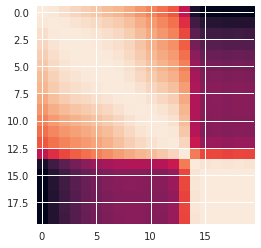

In [14]:
plt.imshow(cov_to_corr(cov))

In [15]:
#np.save('/u/ki/swmclau2/Git/pearce/bin/optimization/xi_box0_emu_cov_lpw.npy', cov)
np.save('/u/ki/swmclau2/Git/pearce/bin/optimization/vdf_box0_emu_cov_lpw.npy', cov)

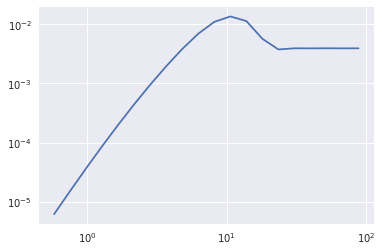

In [16]:
plt.plot(emu.scale_bin_centers, np.sqrt(np.diag(cov)))
#plt.xscale('log')
plt.loglog();

In [17]:
with h5py.File(training_file, 'r') as f:
    #f.attrs['rel_emu_cov'] = rel_cov
    shot_cov = f['cosmo_no_00']['a_1.000']['cov'][()]
    obs = f['cosmo_no_00']['a_1.000']['obs'][()]

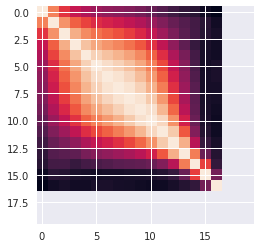

In [18]:
plt.imshow(cov_to_corr(np.mean(shot_cov, axis=0)))

In [19]:
fiducial_hod = {'sigma_logM':0.2, 'logM0': 13.0, 'logM1': 14.0,
                'alpha':1.0,'conc_gal_bias': 1.0,\
                'mean_occupation_centrals_assembias_param1': 0.0,
               'mean_occupation_satellites_assembias_param1': 0.0}

In [20]:
from pearce.mocks.kittens import TrainingBox

In [21]:
cat = TrainingBox(0, system='ki-ls')

In [22]:
cat.load(1.0, HOD='hsabZheng07')

In [23]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=100) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x


In [24]:
add_logMmin(fiducial_hod, cat)

logMmin 13.205627959576999


In [25]:
r_bins = np.logspace(-0.3, 2.0, 21)

In [26]:
N = 10
vals = np.zeros((N, len(r_bins)-1))

for i in xrange(N):
    print i
    cat.populate(fiducial_hod)

    #vals[i] =  cat.calc_xi(r_bins)
    vals[i] = cat.calc_vdf(r_bins, n_ran=1e6)

0
1
2
3
4
5
6
7
8
9


In [39]:
meas_cov = np.cov(vals, rowvar=False)

In [40]:
meas_cov[meas_cov==0] = 1e-4

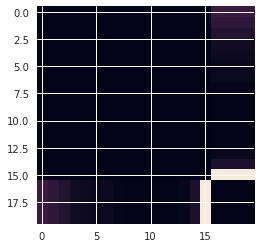

In [41]:
plt.imshow(cov_to_corr(meas_cov))

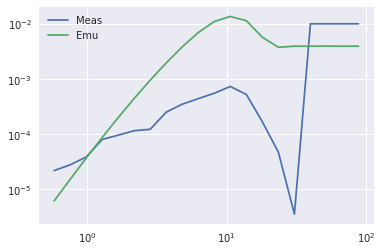

In [42]:
plt.plot(emu.scale_bin_centers, np.sqrt(np.diag(meas_cov)), label = 'Meas')
plt.plot(emu.scale_bin_centers, np.sqrt(np.diag(cov)), label = 'Emu')
plt.loglog();
plt.legend(loc='best')

In [43]:
full_cov = meas_cov + cov
#cov = np.mean(shot_cov, axis=0)

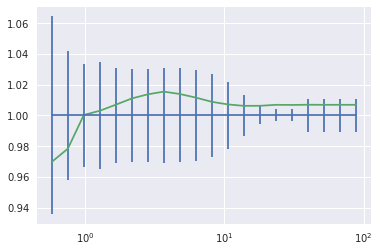

In [44]:
plt.errorbar(emu.scale_bin_centers, np.ones_like(vals.mean(axis=0)),\
             yerr = np.sqrt(np.diag(full_cov))/vals.mean(axis=0) )
if 'logMmin' in fiducial_hod:
    del fiducial_hod['logMmin']
plt.plot(emu.scale_bin_centers, 10**emu.emulate_wrt_r(fiducial_hod).squeeze()/vals.mean(axis=0))
plt.xscale('log');

In [45]:
#np.save('/u/ki/swmclau2/Git/pearce/bin/covmat/xi_box0_full_covmat.npy', full_cov)
np.save('/u/ki/swmclau2/Git/pearce/bin/covmat/vdf_box0_full_covmat.npy', full_cov)